In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('merged_data.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df.head()

,Game_date,Games_played_to_date,BA,PA,Name,ISO,SLG,BABIP,BIP,OBP,...,strike_percentage,pitches_per_appearance_avg,ground_ball_percentage,fly_ball_percentage,strikeout_percentage,next_game_team1,next_game_team2,hitter_R%,hitter_L%,next_game_hit_vs_fp
0,2014-03-31,1,0.00000,4,Travis d'Arnaud,0.0,0.00000,0.00000,0.33333,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0
1,2014-03-31,1,0.20000,5,Jayson Werth,0.0,0.20000,0.33333,0.60000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
2,2014-03-31,1,0.25000,5,Ian Desmond,0.0,0.25000,0.25000,1.00000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
3,2014-03-31,1,0.25000,5,Bryce Harper,0.0,0.25000,0.50000,0.50000,0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0
4,2014-03-31,1,0.33333,5,Adam LaRoche,1.0,1.33333,0.00000,1.00000,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1


In [3]:
train = df[['SLG','BABIP','BIP','OBP','Weather (Degrees)','Wind (MPH)','Innings_Pitched','Hits_Allowed', 'Earned_Runs_Allowed','ERA','hip_last_three','strikeout_percentage' ,'strike_percentage' ,'whip_season' ,'Strikes_Swinging']]
test = df[['next_game_HIT']]

In [4]:
for i in train.columns:    
    if (train.shape[0] - train[i].count()) / train.shape[0] > .3:
        print (i)
        train = train.drop([i], axis = 1)

In [5]:
for i in train.columns:
    if len(train[i].unique()) > 2:
        train[i] = train[i].fillna(train[i].median())
    else:
        train[i] = train[i].fillna(train[i].mode()[0])

C:\Users\Andrew\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


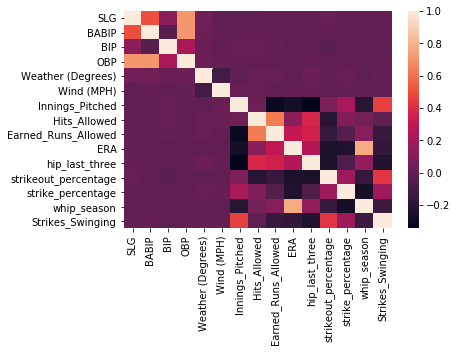

In [6]:
corr = train.corr()
sns.heatmap(corr)

In [7]:
#VIF better for collinearity
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train.columns[columns]
train = train[selected_columns]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

columns = train.columns
train = preprocessing.normalize(train)
train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test)

X, y = train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())
predictions = logreg.predict(X_test)
print (precision_score(y_test, predictions))

0.637897519632999


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


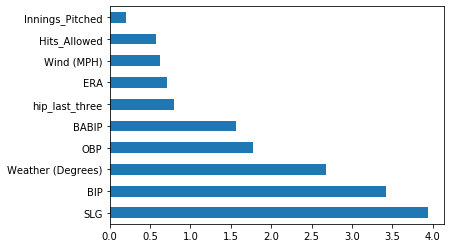

In [10]:
feat_importances = pd.Series(logreg.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

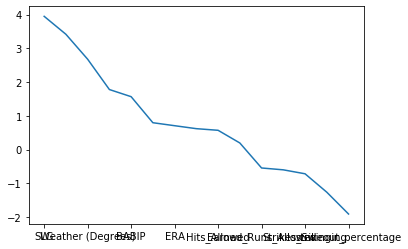

In [11]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line')

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))

0.64185893571546


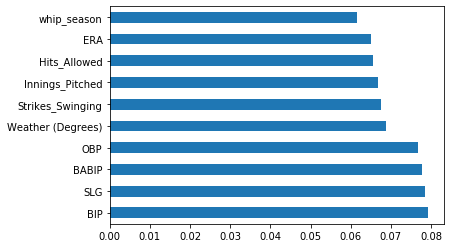

In [13]:
feat_importances = pd.Series(clf.feature_importances_, index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

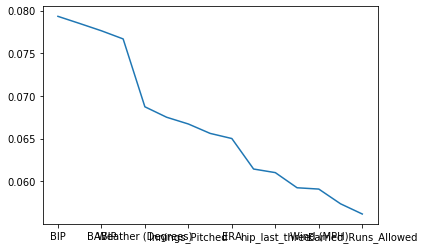

In [14]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line')

In [15]:
#rbf svc too slow
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score

linsvc = LinearSVC()
linsvc.fit(X_train, y_train.values.ravel())
predictions = linsvc.predict(X_test)
print (precision_score(y_test, predictions))

0.6378952825298082


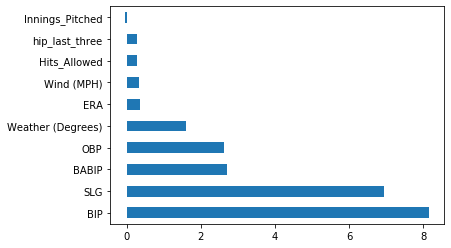

In [17]:
feat_importances = pd.Series(linsvc.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

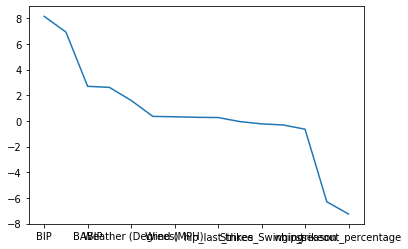

In [18]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line')

In [19]:
train = train.join(df['Name'])
train = train.join(df['next_game_HIT'])
names = train['Name'].unique().tolist()
temp = train['Name'].value_counts().to_frame()
temp = temp.reset_index()
temp.columns = ['Name', 'Count']
for i in range(len(temp)):
    if temp.at[i, 'Count'] < 30:
        names.remove(temp.at[i, 'Name'])

In [20]:
len(df['Name'].unique()) - len(names)

300

In [21]:
len(names) / len(df['Name'].unique()) 

0.7169811320754716

In [22]:
players = pd.DataFrame()

count = 0

for name in names:
    
    players.at[count, 'Name'] = name
    
    train2 = train[train['Name'] == name]
    train2 = train2.drop(['Name'], axis = 1)
    test2 = train2['next_game_HIT']
    train2 = train2.drop(['next_game_HIT'], axis = 1)
    
    players.at[count, 'Samples'] = train2.shape[0]
    
    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing

    columns = train2.columns
    train2 = preprocessing.normalize(train2)
    train2 = pd.DataFrame(train2, columns = columns)
    test2 = pd.DataFrame(test2)

    X, y = train2, test2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_score
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train.values.ravel())
    predictions = logreg.predict(X_test)
    players.at[count, 'LR'] = precision_score(y_test, predictions) 
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import precision_score
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'RF'] = precision_score(y_test, predictions)             
        
    from sklearn.svm import LinearSVC
    from sklearn.metrics import precision_score
    linsvc = LinearSVC()
    linsvc.fit(X_train, y_train.values.ravel())
    predictions = linsvc.predict(X_test)
    players.at[count, 'LinSVC'] = precision_score(y_test, predictions) 
    
    count += 1
               
players.head()

C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precis

,Name,Samples,LR,RF,LinSVC
0,Travis d'Arnaud,365.0,0.726027,0.732143,0.726027
1,Jayson Werth,376.0,0.618421,0.602941,0.618421
2,Ian Desmond,649.0,0.669231,0.689320,0.669231
3,Bryce Harper,728.0,0.623288,0.625000,0.623288
4,Adam LaRoche,198.0,0.600000,0.647059,0.600000


In [23]:
print ('LR: ' + str(players['LR'].mean()))
print ('RF: ' + str(players['RF'].mean()))
print ('LinSVC: ' + str(players['LinSVC'].mean()))

LR: 0.5784433149837
RF: 0.6107323320358553
LinSVC: 0.5930566707499345
